# Topic extraction

Using `tomotopy`'s LDA implementation.
Comparing different number of topics and evaluating coherence.

In [1]:
%load_ext autotime

import psycopg2
import numpy 
import nltk
import wordcloud
import matplotlib.pyplot as plt
import gensim
from tqdm import tqdm
import multiprocessing

DATASET_NAME = '200k-lemma-nophrase'
TOPIC_COUNTS = list(reversed(range(2,60)))
N_REPEATS = 5

# DATASET_NAME = 'small'
# TOPIC_COUNTS = list(reversed(range(2,5)))

In [2]:
def log(message):
    print(message, flush=True)

time: 366 µs


In [3]:
import pickle

log('Loading dataset...')
dataset = pickle.load(open(f'dataset.{DATASET_NAME}.pkl', 'rb'))
data_train = dataset['train']
data_test  = dataset['test']

print("Building gensim corpus...")
gensim_dictionary = gensim.corpora.Dictionary(data_train)

log(f'{len(data_train)} training documents')
log(f'{len(data_test)} test documents')

Loading dataset...
Building gensim corpus...
145664 training documents
36416 test documents
time: 7.16 s


In [4]:
import tomotopy as tp

def prepare_model(k):
    model = tp.LDAModel(
        tw=tp.TermWeight.ONE,
        k=k
#         seed=0
    )
    
    for tokens in data_train:
        model.add_doc(tokens)
    
    return model

time: 1.22 s


In [5]:
import time
import numpy as np
import collections

def train_model(m, max_iter=1000, perp_threshold=1, window=10):
    """
    Train model 'm' until perplexity varies by less than 'perp_threshold'
    
    - max_iter: maximum number of iterations
    - window: number of last iterations to consider for stopping
    - perp_threshold: stop training when perplexity varies by less than this compared to the window median
    
    Returns (time spent, iterations)
    """
    
    t0 = time.time()
    q = collections.deque(maxlen=window)
    iterations = 0
    
#     def log(i,p):
#         print(f'iteration {i}, perplexity {p}')
        
    for iter in range(window):
        m.train(1)
        iterations += 1
        p = m.perplexity
        q.append(p)
#         log(iterations, p)
    for iter in range(max_iter - window):
        m.train(1)
        iterations += 1
        p = m.perplexity
        p_med = np.median(np.asarray(q))
        if p > p_med - perp_threshold: break
        q.append(p)
#         log(iterations, p)
    return (
        time.time() - t0,
        iterations
    )

time: 1.56 ms


In [6]:
# https://towardsdatascience.com/dont-be-afraid-of-nonparametric-topic-models-part-2-python-e5666db347a
# https://github.com/ecoronado92/towards_data_science/blob/master/hdp_example/scripts/model_funcs.py

def get_topic_words(model, top_n=10):
    '''Wrapper function to extract topics from trained tomotopy HDP model 
    
    ** Inputs **
    model:obj -> trained model
    top_n: int -> top n words in topic based on frequencies
    
    ** Returns **
    topics: dict -> per topic, an arrays2 with top words and associated frequencies 
    '''
    
    # Get most important topics by # of times they were assigned (i.e. counts)
    sorted_topics = range(model.k)
    
    topics=dict()
    
    # For topics found, extract only those that are still assigned
    for k in sorted_topics:
        try:
            if not model.is_live_topic(k): continue # remove un-assigned topics at the end (i.e. not alive)
        except AttributeError: 
            pass
        
        topic_wp = model.get_topic_words(k, top_n=top_n)

        topics[k] = topic_wp # store topic word/frequency array
        
    return topics



def eval_coherence(topics_dict, vocab, documents, coherence_type='c_v'):
    '''Wrapper function that uses gensim Coherence Model to compute topic coherence scores
    
    ** Inputs **
    topic_dict: dict -> topic dictionary from train_HDPmodel function
    vocab: gensim.corpora.Dictionary
    documents: list of list of strings
    coherence_typ: str -> type of coherence value to comput (see gensim for opts)
    
    ** Returns **
    3-tuple,
        float -> coherence value
        float list -> per-topic coherence
        float list -> per-topic coherence deviation
    '''
    
    # Build topic list from dictionary
    topic_list=[]
    for k, tups in topics_dict.items():
        topic_tokens = [w for w,p in tups]
        topic_list.append(topic_tokens)
            

    # Build Coherence model
    cm = gensim.models.CoherenceModel(
        topics=topic_list,
        dictionary=vocab,
        texts=documents, 
        coherence=coherence_type,
        processes=16)
    
    return cm.get_coherence()


time: 22.6 ms


In [7]:
#
# FIXME:
# only consider a topic when its score is > some threshold (2x 1/20 ?)

def topic_counts(model, top_n):
    """For each topic, count posts where the topic figure in the `top_n` topics
    
    Returns:
    dict of topic_id (int), posts (int)
    """
    counts = {}
    threshold = 2.0 / model.k
    for k in range(model.k):
        counts[k] = 0
    for doc in tqdm(model.docs):
        for k, v in doc.get_topics(top_n=top_n):
            if v < threshold: next
            counts[k] += 1
    return counts

time: 7.95 ms


In [8]:
# http://qpleple.com/perplexity-to-evaluate-topic-models/
import math

def model_perplexity(model, samples):
    count = 0
    docs = [model.make_doc(s) for s in samples]
    _, log_likelihoods = model.infer(doc=docs)
    lengths = [len(s) for s in samples]
    
    assert len(lengths) == len(log_likelihoods)
    return math.exp(- numpy.sum(numpy.array(log_likelihoods)) / numpy.sum(numpy.array(lengths)))


time: 8.08 ms


In [9]:
models = []
reported_perplexity = {}
train_perplexity = {}
test_perplexity = {}
coherence_c_v = {}
coherence_u_mass = {}
iterations = {}
training_time = {}

log('Preparing models...')
for k in tqdm(TOPIC_COUNTS * N_REPEATS):
    models.append(prepare_model(k))

log('Training models...')
for i,m in tqdm(enumerate(models)):
    t,n = train_model(m)
    iterations[i] = n
    training_time[i] = t

Preparing models...


100%|██████████| 190/190 [02:43<00:00,  1.16it/s]

Training models...



190it [1:26:32, 27.33s/it]

time: 1h 29min 15s


In [10]:
log('Saving reported perplexity...')
for i, model in tqdm(enumerate(models)):
    reported_perplexity[i] = model.perplexity

Saving reported perplexity...


190it [00:09, 19.33it/s]

time: 9.83 s


In [11]:
# log('Calculating test perplexity...')
# for k, model in tqdm(models.items()):
#     test_perplexity[k]  = model_perplexity(model, data_test)

time: 269 µs


In [12]:
# log('Calculating train perplexity...')
# for k, model in tqdm(models.items()):
#     train_perplexity[k] = model_perplexity(model, data_train)

time: 15.3 ms


In [13]:
log('Calculating C_v coherence...')
for i, model in tqdm(enumerate(models)):
    cv = eval_coherence(get_topic_words(model), gensim_dictionary, data_train, coherence_type='c_v')
    coherence_c_v[i] = cv

Calculating C_v coherence...


190it [26:06,  8.24s/it]

time: 26min 6s


In [14]:
log('Calculating U_mass coherence...')
for i, model in tqdm(enumerate(models)):
    cu = eval_coherence(get_topic_words(model), gensim_dictionary, data_train, coherence_type='u_mass')    
    coherence_u_mass[i] = cu

Calculating U_mass coherence...


190it [16:21,  5.16s/it]

time: 16min 21s


In [21]:
# returns x, y_med, y_min, y_max
def prep_metric(data, models):
    d = collections.defaultdict(list)
    for i, v in data.items():
        k = models[i].k
        d[k].append(v)
    x = []
    y = []
    ymin = []
    ymax = []
    for k, l in d.items():
        a = np.array(l)
        x.append(k)
        y.append(np.median(a))
        ymin.append(np.min(a))
        ymax.append(np.max(a))
    
    return (x,y,ymin,ymax)

prep_metric(reported_perplexity, models)

([39,
  38,
  37,
  36,
  35,
  34,
  33,
  32,
  31,
  30,
  29,
  28,
  27,
  26,
  25,
  24,
  23,
  22,
  21,
  20,
  19,
  18,
  17,
  16,
  15,
  14,
  13,
  12,
  11,
  10,
  9,
  8,
  7,
  6,
  5,
  4,
  3,
  2],
 [2914.3867892480066,
  2935.0820425562492,
  2921.539979716611,
  2866.432112486314,
  2909.332858746506,
  2862.6944723751803,
  2885.516163123072,
  2862.6912186751233,
  2801.663544158156,
  2849.4809630883624,
  2862.8749091301424,
  2893.9944312648963,
  2844.1457465701346,
  2777.396560692534,
  2832.7594642267236,
  2830.8460728469076,
  2829.3126256034816,
  2789.320099325737,
  2731.245163362787,
  2710.8013929769995,
  2745.8627448950833,
  2735.359627767802,
  2689.6091443447876,
  2719.24418939393,
  2662.460307202856,
  2618.7576243004387,
  2661.1055288220246,
  2549.564210468758,
  2637.6091158855793,
  2543.9483913883228,
  2552.275142370296,
  2467.833300826525,
  2436.598436582036,
  2448.4916377411323,
  2402.59179666226,
  2325.0689310573043,
  236

time: 12.7 ms


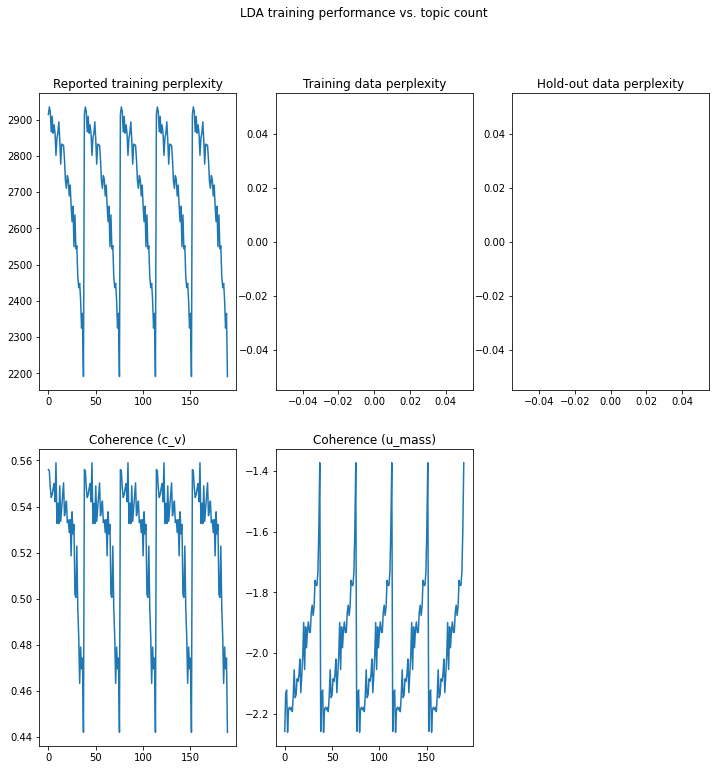

time: 439 ms


In [15]:
fig = plt.figure(figsize=(12,12))
fig.suptitle('LDA training performance vs. topic count')

x = list(reported_perplexity.keys())
y = list(reported_perplexity.values())

plt.subplot(231)
plt.plot(x,y)
plt.title('Reported training perplexity')

x = list(train_perplexity.keys())
y = list(train_perplexity.values())

plt.subplot(232)
plt.plot(x,y)
plt.title('Training data perplexity')

x = list(test_perplexity.keys())
y = list(test_perplexity.values())

plt.subplot(233)
plt.plot(x,y)
plt.title('Hold-out data perplexity')

x = list(coherence_c_v.keys())
y = list(coherence_c_v.values())

plt.subplot(234)
plt.plot(x,y)
plt.title('Coherence (c_v)')

x = list(coherence_u_mass.keys())
y = list(coherence_u_mass.values())

plt.subplot(235)
plt.plot(x,y)
plt.title('Coherence (u_mass)')

plt.show()

